In [ ]:
import numpy as np


def im2col(input_data, filter_h, filter_w, stride, pad, constant_values=0):
    """畳み込みの対象となる領域をベクトル化し，それを並べた行列を作成する処理
    input_data : (データ数, チャンネル数, 高さ, 幅)の4次元配列
    filter_h : フィルタの高さ
    filter_w : フィルタの幅
    stride : ストライドサイズ
    pad : パディングサイズ
    constant_values : パディング処理で埋める際の値
    """

    # 入力データのデータ数, チャンネル数, 高さ, 幅を取得
    N, C, H, W = input_data.shape

    # 出力データの高さ(端数は切り捨てる)
    out_h = (H + 2 * pad - filter_h) // stride + 1

    # 出力データの幅(端数は切り捨てる)
    out_w = (W + 2 * pad - filter_w) // stride + 1

    # パディング処理
    """単純に上下左右の領域に値を付け加える処理
    - 第1引数: パディングの対象となるデータ
    - 第2引数: 次元ごとに先頭と末尾に何個ずつ値を追加するかを指定する。
            [(第0次元の先頭に追加する個数, 第0次元の末尾に追加する個数), 
            (第1次元の先頭に追加する個数, 第1次元の末尾に追加する個数),...,
            (第d次元の先頭に追加する個数, 第d次元の末尾に追加する個数)]
    - 第3引数: パディングの種類。constantを指定した場合は，引数constant_valuesに指定した値を使ってパディングする
    - 第4引数: constant_values
    """
    img = np.pad(
        input_data,
        [(0, 0), (0, 0), (pad, pad), (pad, pad)],
        "constant",
        constant_values=constant_values,
    )

    # 配列の初期化
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    # フィルタ内のある1要素に対応する画像中の画素を取り出してcolに代入
    # ※処理の解説:https://qiita.com/kurumen-b/items/236c6255959a266cefaa
    for y in range(filter_h):
        y_max = y + stride * out_h 
        for x in range(filter_w):
            x_max = x + stride * out_w
            # y_maxまでstride刻みで値を取得し，横方向にはx_maxまでstride刻みで値を取得
            # 以下図のfilter_wの部分に注視。各セクションに積層されたパッチ数を表す？
            # stride刻みで各パッチを計算している⇒数値に注目
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    # 軸を入れ替えて、2次元配列(行列)に変換する
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    # 最終的なcolのshapeは[データ数×縦の出力サイズ×横の出力サイズ，チャンネル数×縦のフィルターサイズ×横のフィルターサイズ]
    return col





入力データとcolの数値に注目

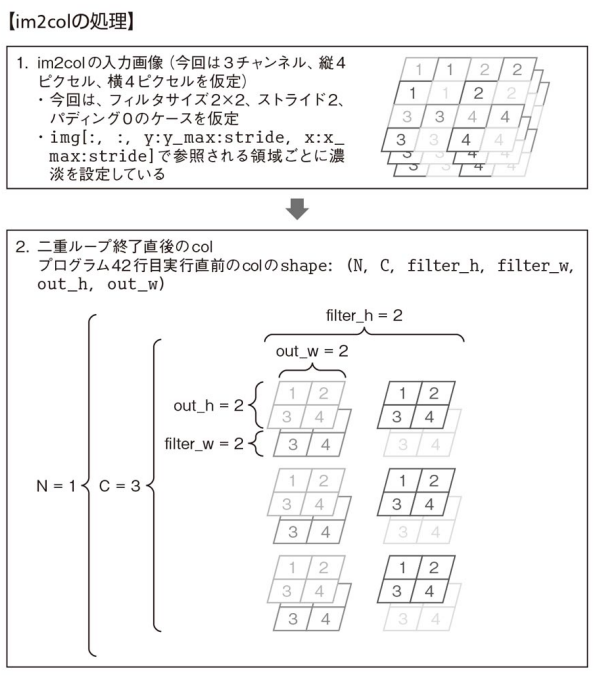

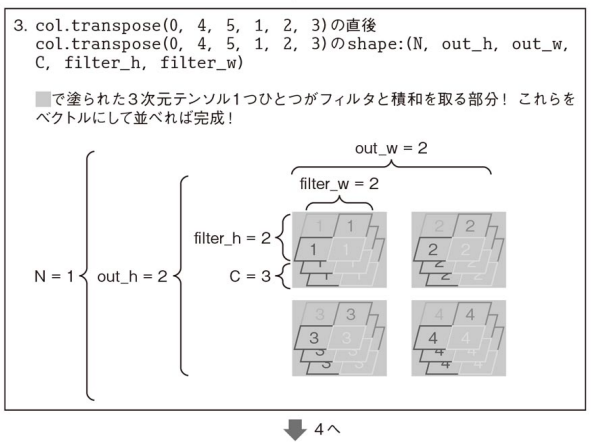

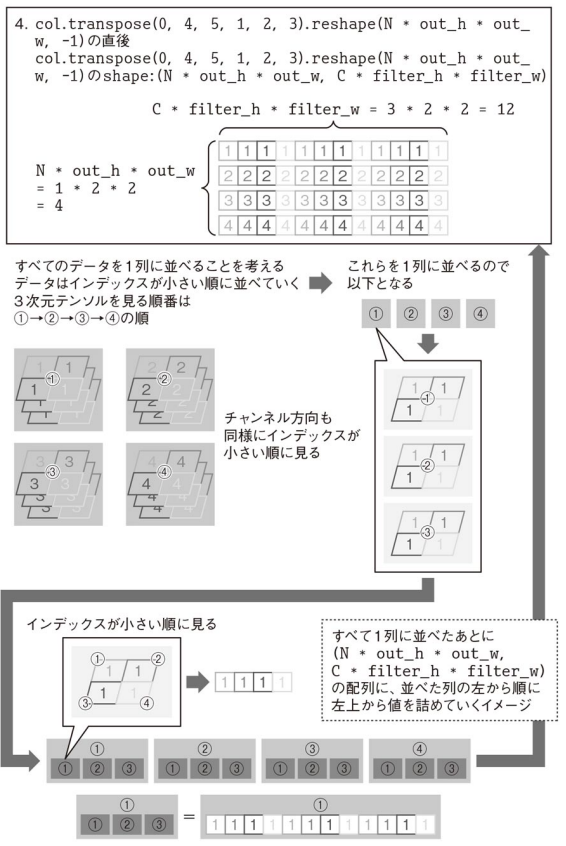

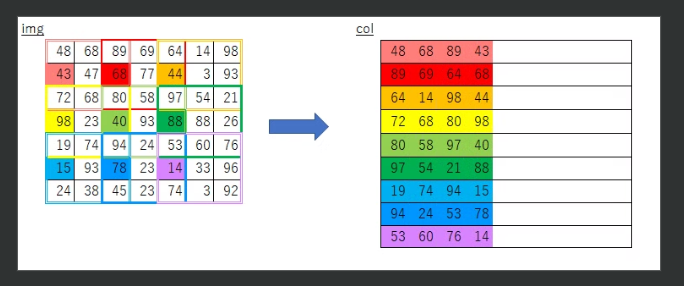

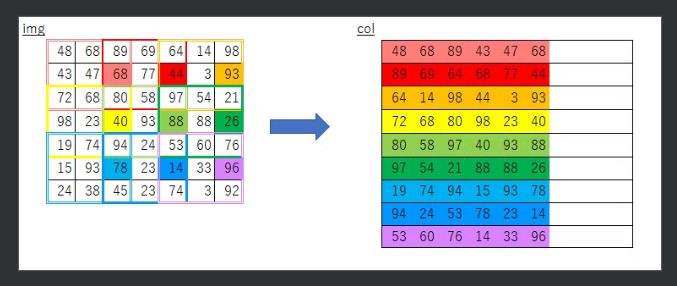

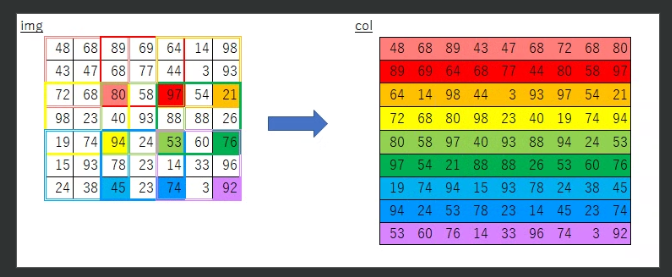

In [ ]:

def maxpooling_forward(x, pad, stride, pool_h, pool_w):
    """
    x : 入力データ, 配列形状 = (データ数, チャンネル数, 高さ, 幅)
    pad : パディングサイズ
    stride : ストライドサイズ
    pool_h : プーリング領域の縦
    pool_w : プーリング領域の横
    """

    N, C, H, W = x.shape

    # 出力の高さ(端数は切り捨てる)
    out_h = (H + 2 * pad - pool_h) // stride + 1

    # 出力の幅(端数は切り捨てる)
    out_w = (W + 2 * pad - pool_w) // stride + 1

    # 2次元配列に変換する（先の処理の結果を受け取り）
    col = im2col(x, pool_h, pool_w, stride, pad, constant_values=0)

    # チャンネル方向のデータが横に並んでいるので、縦に並べ替える
    col = col.reshape(-1, pool_h * pool_w)

    # 最大値と最大値のインデックス（逆伝播時に使用）を求める
    # 各行の最大値インデックス(列)を，各列の値を比較して求める
    out_idx = np.argmax(col, axis=1)

    # 最大値を求める
    # 各行の最大値を，各列の値を比較して求める
    out = np.max(col, axis=1)

    # 画像形式に戻して、チャンネルの軸を2番目に移動させる
    out = out.reshape(N, out_h, out_w, C). transpose(0, 3, 1, 2)

    return out_idx, out





チャンネル軸を行方向にも持っているため，　

[データ数×縦の出力サイズ×横の出力サイズ，チャンネル数×縦のフィルターサイズ×横のフィルターサイズ]

↓

[データ数×縦の出力サイズ×横の出力サイズ×チャンネル数，縦のフィルターサイズ×横のフィルターサイズ]

※チャンネル軸を行方向に持ってくる，の箇所

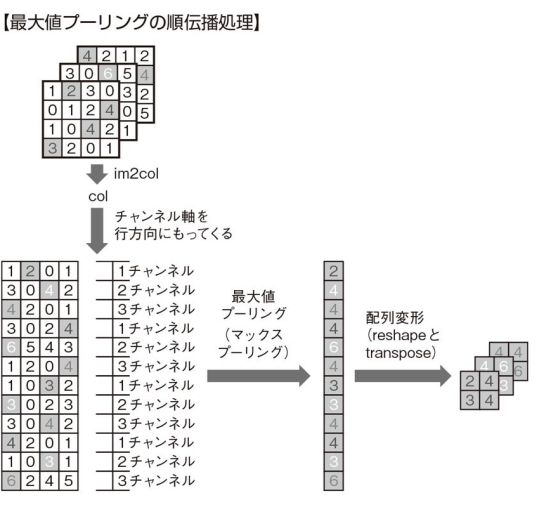

In [ ]:
def convolution_forward(x, W, b, pad, stride):
    """
    x : 入力データ, 配列形状 = (データ数, チャンネル数, 高さ, 幅)
    W : フィルタ, 配列形状 = (出力チャンネル数, 入力チャンネル数, 高さ, 幅)
    b : バイアス
    pad : パディングサイズ
    stride : ストライドサイズ
    """

    FN, C, FH, FW = W.shape
    N, C, IH, IW = x.shape

    # 出力の高さ(端数は切り捨てる)
    out_h = (IH + 2 * pad - FH) // stride + 1

    # 出力の幅(端数は切り捨てる)
    out_w = (IW + 2 * pad - FW) // stride + 1

    # 畳み込み演算を効率的に行えるようにするため、入力xを行列colに変換する
    col = im2col(x, FH, FW, stride, pad)

    # フィルタを2次元配列に変換する
    # colの各行には１枚分のフィルタによって畳み込まれる値が並ぶ
    # FNは出力チャンネル数⇒フィルタの枚数(列数)はチャンネル枚数と同じFNにする必要がある
    # 変換後のshapeは[入力チャンネル数×縦のフィルタサイズ×横のフィルタサイズ，出力チャンネル数]
    # 出力次元をcol_Wの列数に持ってくる考え方！
    col_W = W.reshape(FN, -1).T

    # 行列の積を計算し、バイアスを足す
    out = np.dot(col, col_W) + b

    # 画像形式に戻して、チャンネルの軸を2番目に移動させる
    out = out.reshape(N, out_h, out_w, -1). transpose(0, 3, 1, 2)

    return out

この関数では、畳み込み演算を効率的に行うために、フィルタ $ W $ を2次元配列に変換しています。以下にその理由を詳しく説明します。

### 背景
畳み込み演算では、入力画像に対して複数のフィルタを適用し、出力画像を生成します。これを効率よく計算するために、一般的に以下の手順を踏みます。

1. **入力データの展開（im2col）**: 入力データ $ x $ を適切な形に展開し、行列 $ col $ に変換します。これにより、畳み込み操作が行列積として表現できるようになります。
2. **フィルタの展開**: フィルタ $ W $ を2次元配列に変換します。この変換が `col_W = W.reshape(FN, -1).T` です。

### フィルタの展開の詳細
元のフィルタ $ W $ の形状は $(FN, C, FH, FW)$ です。ここで、 $ FN $ は出力チャンネル数、 $ C $ は入力チャンネル数、 $ FH $ はフィルタの高さ、 $ FW $ はフィルタの幅を表します。

このフィルタを行列積として利用するためには、以下のように展開する必要があります：

- **2次元配列に変換**: `W.reshape(FN, -1)` により、 $ W $ を形状 $(FN, C \cdot FH \cdot FW)$ の2次元配列に変換します。これは、各フィルタを1次元に展開したものを1行とする行列です。
- **転置**: `col_W = W.reshape(FN, -1).T` により、この2次元配列を転置し、形状 $(C \cdot FH \cdot FW, FN)$ とします。これにより、行列積を計算する際に、入力 $ col $ の各行とフィルタの展開形の内積を取ることができます。

### なぜ転置するのか？
転置する理由は、行列積を計算する際の次元の整合性を保つためです。具体的には：

- **入力 $ col $**: 形状 $(N \cdot out_h \cdot out_w, C \cdot FH \cdot FW)$
- **フィルタ $ col_W $**: 形状 $(C \cdot FH \cdot FW, FN)$

このようにすることで、行列積 `np.dot(col, col_W)` の結果は形状 $(N \cdot out_h \cdot out_w, FN)$ となり、これをさらに適切な形にリシェイプして出力として返すことができます。

### まとめ
フィルタ $ W $ を2次元配列に変換し転置する理由は、畳み込み演算を行列積として効率的に計算するためです。これにより、大規模な畳み込み演算も高速に実行することが可能になります。

In [ ]:
if __name__=="__main__":
    x = np.arange(2*3*28*28).reshape(2, 3, 28 ,28)
    print("x\n", x)
    pad = 1
    stride = 1
    pool_h = 3
    pool_w = 3
    out_idx, out = maxpooling_forward(x, pad, stride, pool_h, pool_w)
    print("out_idx\n", out_idx)
    print("out\n", out)
    
    x = np.arange(2*3*28*28).reshape(2, 3, 28 ,28)
    print("x\n", x)    
    W = np.arange(5*3*3*3).reshape(5, 3, 3, 3)
    print("W\n", W) 
    b = np.array([1])
    print("b\n", b)
    pad = 1
    stride = 1    
    out = convolution_forward(x, W, b, pad, stride)